In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [59]:
#Sklean no tiene el error porcentual medio (MPE) lo vamos a crear nosotros
def mean_porcentual_error(yreal, ypred):
    return np.mean((yreal-ypred)/yreal)

In [64]:
import statsmodels.api as sm

Acceso al [Kaggle](https://www.kaggle.com/datasets/yashkmd/credit-profile-two-wheeler-loan-dataset)
- Se puede plantear un problema de regresión con el score.
- Se puede plantear un problema de clasificación con un umbral (o varios) para ver si pasa o no.

In [3]:
# Generamos el dataset
credit = pd.read_csv('credit_data.csv')
credit.head()

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker
3,69,Female,46000,668,349,6,150000,148,Yes,Karnataka,Bengaluru,87.393365,Self-Employed,86,Contractor
4,52,Male,132000,601,553,5,150000,157,No,Karnataka,Mysuru,66.158757,Salaried,90,Teacher


In [4]:
# Revisamos la información de las columnas
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

In [5]:
# Solamente tenemos valores nulos en ocupación --> puede ser una oportunidad para ver qué hay demográficamente
credit.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  18272
dtype: int64

In [6]:
# No es despreciable la cantidad de NaN --> quizas podemos dejarlos como "otros" (aunque no sé si es informativo)
credit.Occupation.value_counts(dropna=False)

Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
NaN                       18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: Occupation, dtype: int64

In [7]:
# Se reemplazan los vacíos por Other
credit.Occupation.fillna('Other',inplace=True)

In [8]:
credit.Occupation.value_counts(dropna=False)

Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
Other                     18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: Occupation, dtype: int64

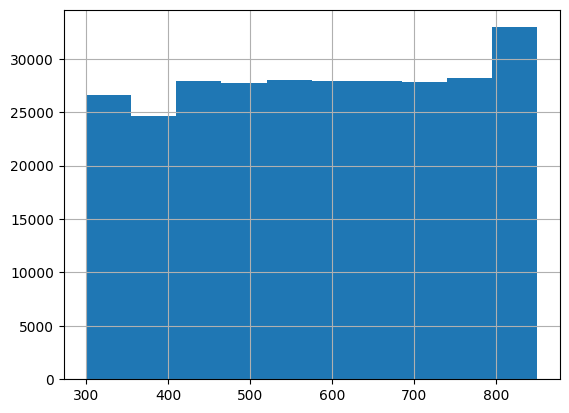

In [9]:
# Podemos ver la distribución de los score
credit['Credit Score'].hist();

In [10]:
# Definimos la variable score como la máscara ante el valor medio de score. De esta manera, exigimos a la clase target que esté balanceada
score = credit['Credit Score'].copy()
mean_score = score.mean()
score = score.apply(lambda x: 1 if x>=mean_score else 0)
score.value_counts()

1    140817
0    139039
Name: Credit Score, dtype: int64

In [11]:
# Definimos quienes serán la X y la y
X = credit.drop('Credit Score', axis=1)
y = score

In [12]:
# Vemos cuales son las variables numericas y cuales las categóricas
numericas = ['Age','Income','Credit History Length','Number of Existing Loans', 'Loan Amount', 'Loan Tenure','LTV Ratio','Profile Score']
categoricas = ['Gender', 'Existing Customer', 'State', 'City', 'Employment Profile', 'Occupation']

In [13]:
# Corroboramos que estén todos los features
len(numericas) + len(categoricas) == len(X.columns)

True

In [14]:
# Realizamos un escalado de las numericas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numericas])
X_scaled = pd.DataFrame(X_scaled, columns=X[numericas].columns)

In [15]:
# Revisamos si los valores numericos tienen un skew
X_scaled.skew().sort_values()

Profile Score              -1.014552
Loan Amount                -0.439019
LTV Ratio                  -0.180826
Age                        -0.002411
Credit History Length       0.009495
Number of Existing Loans    0.053826
Income                      0.708779
Loan Tenure                 0.842224
dtype: float64

In [16]:
# Vemos las variables categóricas
X[categoricas].head()

,Gender,Existing Customer,State,City,Employment Profile,Occupation
0,Male,No,Karnataka,Mysuru,Salaried,Doctor
1,Male,No,Karnataka,Bengaluru,Salaried,Software Engineer
2,Other,Yes,Uttar Pradesh,Kanpur,Salaried,Banker
3,Female,Yes,Karnataka,Bengaluru,Self-Employed,Contractor
4,Male,No,Karnataka,Mysuru,Salaried,Teacher


In [17]:
# Aplicamos un encoding para que tengan valores numericos
dummies = pd.get_dummies(X[categoricas])
dummies.head()

,Gender_Female,Gender_Male,Gender_Other,Existing Customer_No,Existing Customer_Yes,State_Delhi,State_Gujarat,State_Karnataka,State_Kerala,State_Maharashtra,...,Occupation_Farmer,Occupation_Graphic Designer,Occupation_Independent Consultant,Occupation_Other,Occupation_Photographer,Occupation_Shopkeeper,Occupation_Software Engineer,Occupation_Student,Occupation_Teacher,Occupation_Writer
0,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# Chequeamos todas las columnas para ver cuál quitar
dummies.columns

Index(['Gender_Female', 'Gender_Male', 'Gender_Other', 'Existing Customer_No',
       'Existing Customer_Yes', 'State_Delhi', 'State_Gujarat',
       'State_Karnataka', 'State_Kerala', 'State_Maharashtra',
       'State_Rajasthan', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'State_West Bengal', 'City_Ahmedabad',
       'City_Bengaluru', 'City_Bishanpura', 'City_Channarayapatna',
       'City_Chennai', 'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad',
       'City_Jaipur', 'City_Kanpur', 'City_Kochi', 'City_Kolkata',
       'City_Lucknow', 'City_Manjari', 'City_Mumbai', 'City_Mysuru',
       'City_Nagpur', 'City_Nellikuppam', 'City_New Delhi', 'City_Pune',
       'City_Surat', 'City_Thiruvananthapuram', 'City_Udaipur',
       'Employment Profile_Freelancer', 'Employment Profile_Salaried',
       'Employment Profile_Self-Employed', 'Employment Profile_Student',
       'Employment Profile_Unemployed', 'Occupation_Banker',
       'Occupation_Business Owner', 

In [20]:
# Eliminamos una columna de cada clase para que sean mutuamente excluyentes
X_cat = dummies.drop([
    'Gender_Other',
    'Existing Customer_No',
    'State_West Bengal',
    'City_Udaipur',
    'Employment Profile_Unemployed',
    'Occupation_Other'
], axis=1)

In [23]:
# Generamos el nuevo dataframe X con el scaled y el cat
X_new = pd.concat([X_scaled, X_cat], axis=1)

In [24]:
# Revisamos si las columnas son las correspondientes
X_new.columns

Index(['Age', 'Income', 'Credit History Length', 'Number of Existing Loans',
       'Loan Amount', 'Loan Tenure', 'LTV Ratio', 'Profile Score',
       'Gender_Female', 'Gender_Male', 'Existing Customer_Yes', 'State_Delhi',
       'State_Gujarat', 'State_Karnataka', 'State_Kerala', 'State_Maharashtra',
       'State_Rajasthan', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'City_Ahmedabad', 'City_Bengaluru',
       'City_Bishanpura', 'City_Channarayapatna', 'City_Chennai',
       'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad', 'City_Jaipur',
       'City_Kanpur', 'City_Kochi', 'City_Kolkata', 'City_Lucknow',
       'City_Manjari', 'City_Mumbai', 'City_Mysuru', 'City_Nagpur',
       'City_Nellikuppam', 'City_New Delhi', 'City_Pune', 'City_Surat',
       'City_Thiruvananthapuram', 'Employment Profile_Freelancer',
       'Employment Profile_Salaried', 'Employment Profile_Self-Employed',
       'Employment Profile_Student', 'Occupation_Banker',
       'Occupati

### Modelos de Clasificación

In [27]:
# Realizamos el split de los datos para generar los modelos
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.15, random_state=17)

In [30]:
# Revisamos el shape de cada uno
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (237877, 60)
X_test shape:  (41979, 60)
y_train shape:  (237877,)
y_test shape:  (41979,)


In [33]:
# Revisamos si el target está balanceado, sino cambiamos el random_state
print("y_train balance:\n", y_train.value_counts())
print("y_test balance:\n", y_test.value_counts())

y_train balance:
 1    119753
0    118124
Name: Credit Score, dtype: int64
y_test balance:
 1    21064
0    20915
Name: Credit Score, dtype: int64


In [36]:
# Implementamos el modelo de LogisticRegression
log_reg = LogisticRegression(solver='newton-cholesky') # Se modifica el solver por no converger "lbfgs"

In [37]:
log_reg.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

In [40]:
# Predecimos los resultados a traves del test
y_pred = log_reg.predict(X_test)
y_pred.shape

(41979,)

In [45]:
# Conocemos los scores del modelo frente al test
print(confusion_matrix(y_test, y_pred))

[[20326   589]
 [   36 21028]]


In [44]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.972     0.985     20915
           1      0.973     0.998     0.985     21064

    accuracy                          0.985     41979
   macro avg      0.985     0.985     0.985     41979
weighted avg      0.985     0.985     0.985     41979



### Modelos de Regresión

In [46]:
# Usamos el X_new como features de entrada del modelo
X_new.head()

,Age,Income,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,LTV Ratio,Profile Score,Gender_Female,Gender_Male,...,Occupation_Doctor,Occupation_Farmer,Occupation_Graphic Designer,Occupation_Independent Consultant,Occupation_Photographer,Occupation_Shopkeeper,Occupation_Software Engineer,Occupation_Student,Occupation_Teacher,Occupation_Writer
0,-0.849402,-0.944576,1.022572,0.100091,0.088428,0.912510,1.144350,-0.014287,0,1,...,1,0,0,0,0,0,0,0,0,0
1,-1.241277,-0.618049,0.445702,-0.906503,1.092598,-0.461574,1.155724,-1.401524,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1.175283,2.367339,1.113957,1.777749,-0.907016,-0.242970,-1.876175,0.516127,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.632470,-0.711342,0.234374,0.435623,1.092598,0.152600,0.933861,0.352923,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.522159,1.294465,1.399536,0.100091,1.092598,0.246287,-0.325176,0.516127,0,1,...,0,0,0,0,0,0,0,0,1,0


In [49]:
# Como variable target vamos a usar el score como tal, pero lo vamos a escalar
y_target = credit['Credit Score']
y_target[:5]

0    604
1    447
2    850
3    668
4    601
Name: Credit Score, dtype: int64

In [50]:
# Hacemos el split con el mismo porcentaje de testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_target, test_size=0.15, random_state=17)

In [52]:
# Realizamos una regresión lineal
lin_reg = LinearRegression()

In [53]:
# Fiteamos a los datos de entrenamiento
lin_reg.fit(X_train, y_train)

LinearRegression()

In [55]:
print(f"El valor de la interseccion de la recta sera {lin_reg.intercept_ }")
print(f"Los valores de los coeficientes de la recta sera {lin_reg.coef_ }")

El valor de la interseccion de la recta sera 583.8009316546593
Los valores de los coeficientes de la recta sera [-1.10954682e-03  5.74667581e-01 -1.65816237e-03  1.51291922e+02
  6.44403423e-03  1.30717270e+00  2.88670564e+00  8.96314958e+00
 -6.92139223e-02 -4.79477007e-02  1.06784259e+01 -5.69692673e-01
  1.04132203e+00 -8.16635537e-01 -7.37005365e-01  1.45367014e-01
 -1.55002229e+00 -3.85496684e-01  1.72498066e-01 -1.52320675e+00
 -3.01381875e+00 -1.19384594e+00 -5.65297738e-01 -3.58211814e-01
 -1.17831897e+00 -1.47670386e+00 -7.68970524e-01 -1.76360049e+00
  2.63680061e-02 -2.49420758e-01 -8.62148752e-01 -1.54407359e+00
  3.65694393e-02 -1.42097048e+00 -1.64191375e+00 -1.17083056e+00
 -1.80724751e+00 -1.03976772e+00 -9.54889216e-01 -1.83395528e+00
 -3.16415484e+00 -7.87603393e-01 -2.25409721e+11 -2.05495548e+12
  2.53719309e+13 -6.22261623e+11  2.05495548e+12 -2.53719309e+13
  2.05495548e+12 -2.53719309e+13  2.05495548e+12 -2.53719309e+13
  2.25409721e+11  2.25409721e+11  2.2540972

In [56]:
print(f"El coeficiente de Pearson es {lin_reg.score(X_train, y_train)}")

El coeficiente de Pearson es 0.9902740028627143


In [57]:
# Calculamos el desvío estándar del modelo
std_dev_model = np.sqrt((np.sum((y_train - lin_reg.predict(X_train))**2))/(y_train.size-60)) # 60 son los features?
print(f"Desvío estándar del modelo {std_dev_model}")

Desvío estándar del modelo 16.090843467637306


In [60]:
# Calculamos el target predicho
y_pred = lin_reg.predict(X_test)

In [62]:
# Analizamos los scores
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.9901525168477157
Error absoluto medio: 13.794787439491401
Error cuadratico medio: 260.7504696891346
Raiz de error cuadratico medio: 16.147769805429313
Error absoluto porcentual medio: 2.63%
Error porcentual medio: -0.16%


In [66]:
# El modelo de statsmodel necesita una entrada para el termino independiente.
# Para ello vamos a agregar una columna de 1 en la primera columna
X_statsmodels = np.append(arr = np.ones((X_new.shape[0],1)).astype(int), values = X_new, axis = 1)

# Nivel de significancia que vamos a usar
SL = 0.05

In [69]:
X_statsmodels.shape

(279856, 61)

In [72]:
# Aplicamos summary con todos los features
X_opt = X_statsmodels[:, :]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Credit Score   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 1.838e+04
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:03:03   Log-Likelihood:                 12791.
No. Observations:              279856   AIC:                        -2.547e+04
Df Residuals:                  279799   BIC:                        -2.487e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4698      0.006     76.037      0.000       0.458       0.482
x1            -0.0009      0.001     -1.666      0.096      -0.002       0.000
x2            -0.0159      0.001    -26.460      0.000      -0.017      -0.015
x3             0.0006      0.000      1.476      0.140      -0.000       0.002
x4             0.2603      0.001    246.467      0.000       0.258       0.262
x5             0.0005      0.000      1.102      0.271      -0.000       0.001
x6             0.1160      0.001    198.468      0.000       0.115       0.117
x7             0.0351      0.001     64.684      0.000       0.034       0.036
x8             0.0570      0.001     70.711      0.000       0.055       0.059
x9            -0.0031      0.002     -1.520      0.128      -0.007       0.001
x10           -0.0011      0.002     -0.525      0.599      -0.005       0.003
x11            0.1699      0.002     98.536      0.000       0.167       0.173
x12           -0.0104      0.005     -2.050      0.040      -0.020      -0.000
x13           -0.0040      0.005     -0.790      0.429      -0.014       0.006
x14           -0.0054      0.005     -1.071      0.284      -0.015       0.004
x15           -0.0117      0.005     -2.331      0.020      -0.022      -0.002
x16           -0.0056      0.005     -1.113      0.266      -0.016       0.004
x17           -0.0033      0.005     -0.642      0.521      -0.013       0.007
x18            0.0070      0.005      1.386      0.166      -0.003       0.017
x19            0.0006      0.005      0.125      0.901      -0.009       0.010
x20           -0.0184      0.005     -3.593      0.000      -0.028      -0.008
x21            0.0060      0.006      1.020      0.308      -0.006       0.018
x22            0.0078      0.006      1.332      0.183      -0.004       0.019
x23            0.0061      0.005      1.287      0.198      -0.003       0.015
x24            0.0044      0.005      0.919      0.358      -0.005       0.014
x25           -0.0109      0.006     -1.864      0.062      -0.022       0.001
x26           -0.0088      0.006     -1.507      0.132      -0.020       0.003
x27           -0.0013      0.005     -0.271      0.787      -0.011       0.008
x28           -0.0040      0.006     -0.710      0.478      -0.015       0.007
x29           -0.0007      0.003     -0.225      0.822      -0.007       0.005
x30            0.0064      0.006      1.079      0.281      -0.005       0.018
x31            0.0128      0.006      2.185      0.029       0.001       0.024
x32           -0.0024      0.006     -0.417      0.677      -0.014       0.009
x33            0.0091      0.006      1.523      0.128      -0.003       0.021
x34            0.0064      0.005      1.351      0.177      -0.003       0.016
x35            0.0071      0.006      1.175      0.240      -0.005       0.019
x3

In [74]:
# Quitamos los que tengan el p-value más alto
X_opt = X_statsmodels[:, range(43)]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Credit Score   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 2.440e+04
Date:                Fri, 08 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:06:17   Log-Likelihood:                 12299.
No. Observations:              279856   AIC:                        -2.451e+04
Df Residuals:                  279813   BIC:                        -2.406e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4440      0.006     75.482      0.000       0.432       0.455
x1            -0.0009      0.001     -1.520      0.129      -0.002       0.000
x2            -0.0180      0.001    -30.168      0.000      -0.019      -0.017
x3             0.0006      0.000      1.288      0.198      -0.000       0.001
x4             0.2650      0.001    253.516      0.000       0.263       0.267
x5             0.0006      0.000      1.327      0.184      -0.000       0.002
x6             0.1164      0.001    198.828      0.000       0.115       0.118
x7             0.0328      0.001     60.963      0.000       0.032       0.034
x8             0.0497      0.001     64.720      0.000       0.048       0.051
x9            -0.0030      0.002     -1.475      0.140      -0.007       0.001
x10           -0.0011      0.002     -0.511      0.609      -0.005       0.003
x11            0.1672      0.002     96.931      0.000       0.164       0.171
x12           -0.0096      0.005     -1.874      0.061      -0.020       0.000
x13           -0.0036      0.005     -0.707      0.480      -0.014       0.006
x14           -0.0047      0.005     -0.932      0.352      -0.015       0.005
x15           -0.0101      0.005     -1.995      0.046      -0.020      -0.000
x16           -0.0041      0.005     -0.817      0.414      -0.014       0.006
x17           -0.0023      0.005     -0.446      0.656      -0.012       0.008
x18            0.0077      0.005      1.533      0.125      -0.002       0.018
x19            0.0009      0.005      0.181      0.856      -0.009       0.011
x20           -0.0177      0.005     -3.459      0.001      -0.028      -0.008
x21            0.0065      0.006      1.105      0.269      -0.005       0.018
x22            0.0081      0.006      1.369      0.171      -0.003       0.020
x23            0.0062      0.005      1.295      0.195      -0.003       0.016
x24            0.0047      0.005      0.989      0.323      -0.005       0.014
x25           -0.0108      0.006     -1.835      0.067      -0.022       0.001
x26           -0.0087      0.006     -1.478      0.139      -0.020       0.003
x27           -0.0013      0.005     -0.263      0.793      -0.011       0.008
x28           -0.0034      0.006     -0.608      0.543      -0.015       0.008
x29           -0.0009      0.003     -0.289      0.773      -0.007       0.005
x30            0.0065      0.006      1.100      0.272      -0.005       0.018
x31            0.0123      0.006      2.085      0.037       0.001       0.024
x32           -0.0015      0.006     -0.260      0.795      -0.013       0.010
x33            0.0092      0.006      1.547      0.122      -0.002       0.021
x34            0.0066      0.005      1.386      0.166      -0.003       0.016
x35            0.0065      0.006      1.067      0.286      -0.005       0.018
x3